# SGAN

In [1]:
import numpy as np
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, LeakyReLU
from tensorflow.keras.layers import Dropout, Lambda, Activation
from tensorflow.keras import backend
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

In [2]:
def custom_activation(output):
	logexpsum = backend.sum(backend.exp(output), axis=-1, keepdims=True)
	result = logexpsum / (logexpsum + 1.0)
	return result

def define_discriminator(in_shape=(28,28,1), n_classes=10):
	in_image = Input(shape=in_shape)
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(in_image)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Flatten()(fe)
	fe = Dropout(0.4)(fe)
	fe = Dense(n_classes)(fe)
	c_out_layer = Activation('softmax')(fe)
	c_model = Model(in_image, c_out_layer)
	c_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5), metrics=['accuracy'])
	d_out_layer = Lambda(custom_activation)(fe)
	d_model = Model(in_image, d_out_layer)
	d_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
	return d_model, c_model

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       1280      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         147584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         147584    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 4, 4, 128)         0   

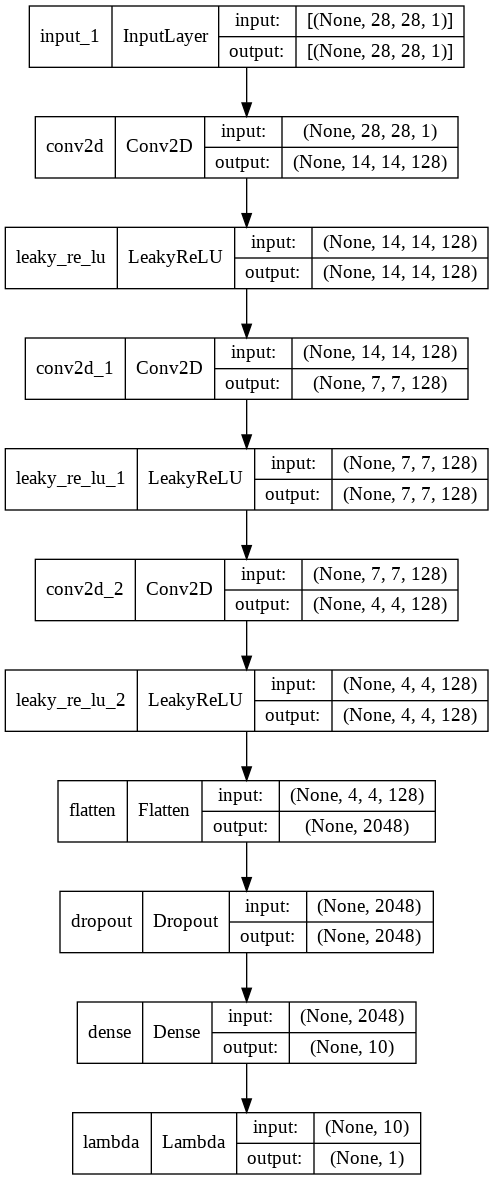

In [3]:
d_model, c_model = define_discriminator()
d_model.summary()
plot_model(d_model, to_file='discriminator1_plot.png', show_shapes=True, show_layer_names=True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       1280      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         147584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         147584    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 4, 4, 128)         0     

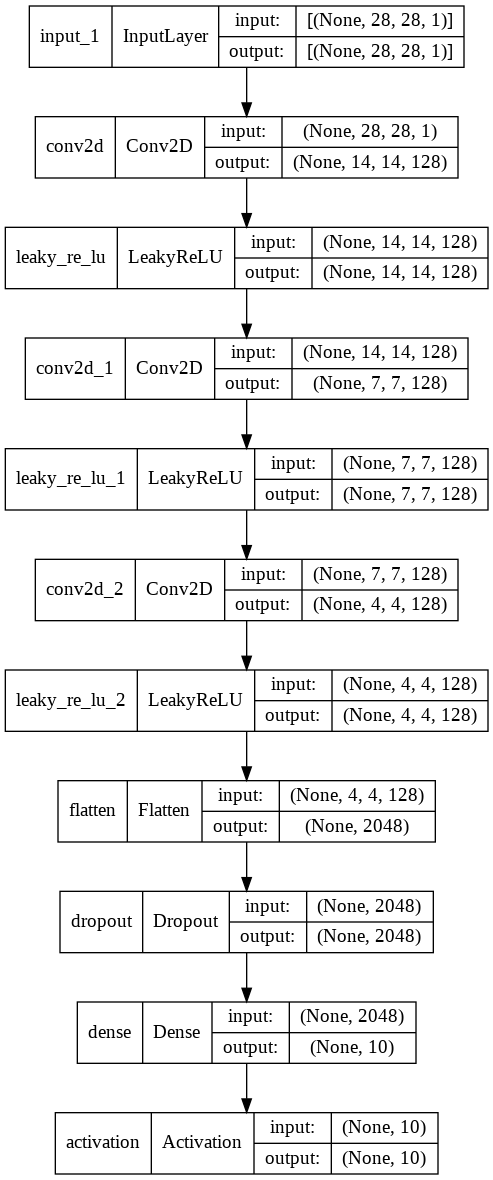

In [4]:
c_model.summary()
plot_model(c_model, to_file='discriminator2_plot.png', show_shapes=True, show_layer_names=True)

In [5]:
def define_generator(latent_dim):
	in_lat = Input(shape=(latent_dim,))
	n_nodes = 128 * 7 * 7
	gen = Dense(n_nodes)(in_lat)
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Reshape((7, 7, 128))(gen)
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
	gen = LeakyReLU(alpha=0.2)(gen)
	out_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(gen)
	model = Model(in_lat, out_layer)
	return model

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_1 (Dense)             (None, 6272)              633472    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                           

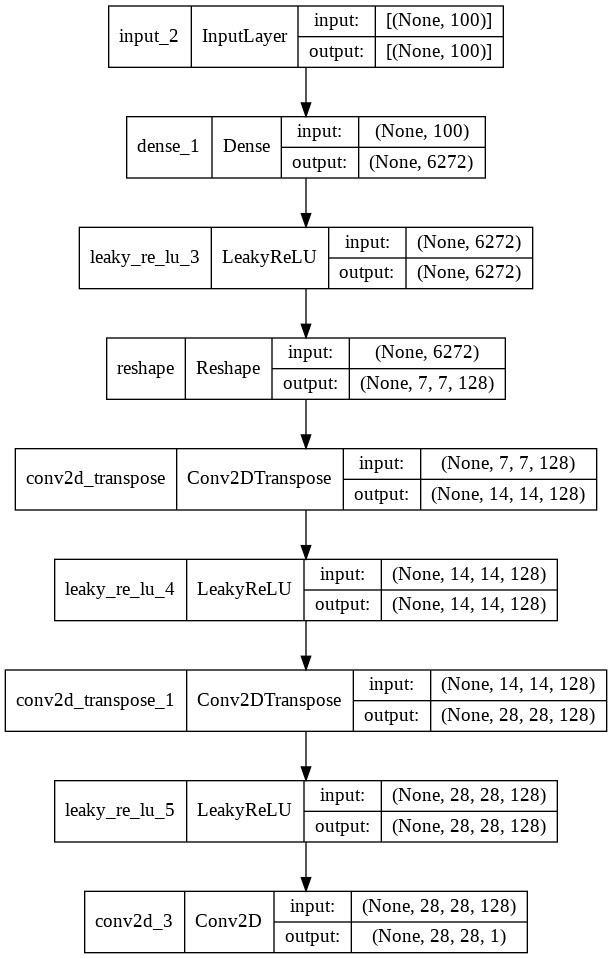

In [6]:
latent_dim = 100
generator_model = define_generator(latent_dim)
generator_model.summary()
plot_model(generator_model, to_file = 'generator_model.png', show_shapes = True, show_layer_names = True)

In [7]:
def define_gan(g_model, d_model):
	d_model.trainable = False
	gan_output = d_model(g_model.output)
	model = Model(g_model.input, gan_output)
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_1 (Dense)             (None, 6272)              633472    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                           

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


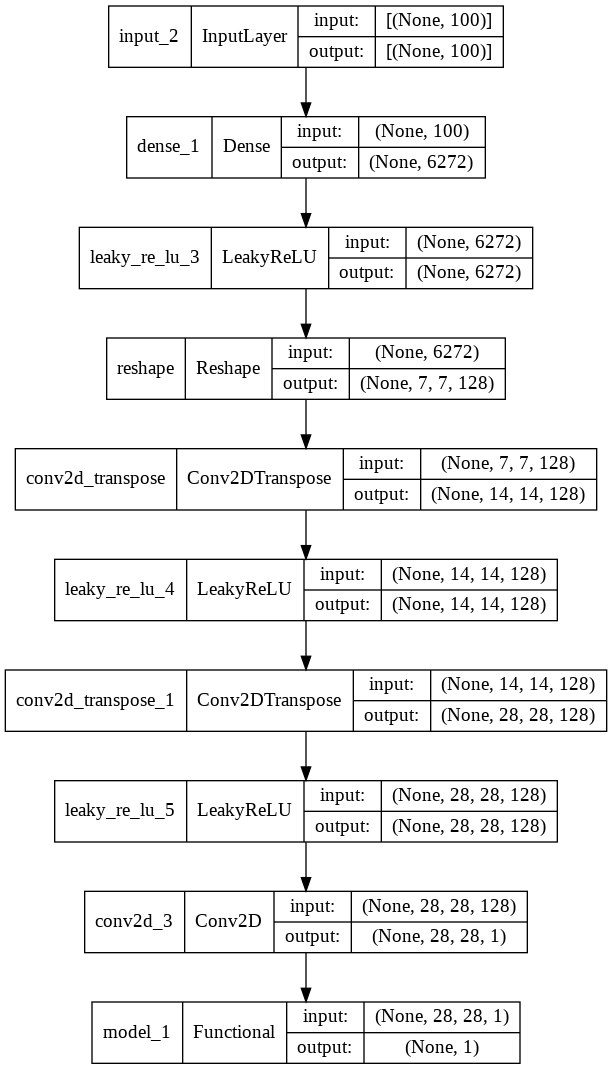

In [8]:
gan_model = define_gan(generator_model, d_model)
gan_model.summary()
plot_model(gan_model, to_file = 'gan_model.png', show_layer_names = True, show_shapes = True)

In [9]:
def load_real_samples():
	(trainX, trainy), (_, _) = load_data()
	X = np.expand_dims(trainX, axis=-1)
	X = X.astype('float32')
	X = (X - 127.5) / 127.5
	print(X.shape, trainy.shape)
	return [X, trainy]

def select_supervised_samples(dataset, n_samples=100, n_classes=10):
	X, y = dataset
	X_list, y_list = list(), list()
	n_per_class = int(n_samples / n_classes)
	for i in range(n_classes):
		X_with_class = X[y == i]
		ix = np.random.randint(0, len(X_with_class), n_per_class)
		[X_list.append(X_with_class[j]) for j in ix]
		[y_list.append(i) for j in ix]
	return np.asarray(X_list), np.asarray(y_list)

def generate_real_samples(dataset, n_samples):
	images, labels = dataset
	ix = np.random.randint(0, images.shape[0], n_samples)
	X, labels = images[ix], labels[ix]
	y = np.ones((n_samples, 1))
	return [X, labels], y

In [10]:
def generate_latent_points(latent_dim, n_samples):
	z_input = np.random.randn(latent_dim * n_samples)
	z_input = z_input.reshape(n_samples, latent_dim)
	return z_input

def generate_fake_samples(generator, latent_dim, n_samples):
	z_input = generate_latent_points(latent_dim, n_samples)
	images = generator.predict(z_input)
	y = np.zeros((n_samples, 1))
	return images, y

In [11]:
def summarize_performance(step, g_model, c_model, latent_dim, dataset, n_samples=100):
	X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
	X = (X + 1) / 2.0
	for i in range(100):
		plt.subplot(10, 10, 1 + i)
		plt.axis('off')
		plt.imshow(X[i, :, :, 0], cmap='gray_r')
	filename1 = 'generated_plot_%04d.png' % (step+1)
	plt.savefig(filename1)
	plt.show()
	X, y = dataset
	_, acc = c_model.evaluate(X, y, verbose=0)
	print('Classifier Accuracy: %.3f%%' % (acc * 100))
	filename2 = 'g_model_%04d.h5' % (step+1)
	g_model.save(filename2)
	filename3 = 'c_model_%04d.h5' % (step+1)
	c_model.save(filename3)
	print('=> Saved: %s, %s, and %s' % (filename1, filename2, filename3))

In [12]:
def train(g_model, d_model, c_model, gan_model, dataset, latent_dim, n_epochs=20, n_batch=100):
  X_sup, y_sup = select_supervised_samples(dataset)
  print(X_sup.shape, y_sup.shape)
  bat_per_epo = int(dataset[0].shape[0] / n_batch)
  n_steps = bat_per_epo * n_epochs
  half_batch = int(n_batch / 2)
  print('n_epochs=%d, n_batch=%d, 1/2=%d, b/e=%d, steps=%d' % (n_epochs, n_batch, half_batch, bat_per_epo, n_steps))
  for i in range(n_steps):
    [Xsup_real, ysup_real], _ = generate_real_samples([X_sup, y_sup], half_batch)
    c_loss, c_acc = c_model.train_on_batch(Xsup_real, ysup_real)
    [X_real, _], y_real = generate_real_samples(dataset, half_batch)
    d_loss1 = d_model.train_on_batch(X_real, y_real)
    X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
    d_loss2 = d_model.train_on_batch(X_fake, y_fake)
    X_gan, y_gan = generate_latent_points(latent_dim, n_batch), np.ones((n_batch, 1))
    g_loss = gan_model.train_on_batch(X_gan, y_gan)
    if (i+1) in (1, n_steps) or (i+1) % 100 == 0:
      print('> Step %d: c_loss-acc[%.3f, %.0f], d_loss[%.3f, %.3f], g_loss[%.3f]' % (i+1, c_loss, c_acc*100, d_loss1, d_loss2, g_loss))
    if (i+1) % (bat_per_epo * 1) == 0:
      summarize_performance(i, g_model, c_model, latent_dim, dataset)

In [13]:
latent_dim = 100
d_model, c_model = define_discriminator()
g_model = define_generator(latent_dim)
gan_model = define_gan(g_model, d_model)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [14]:
dataset = load_real_samples()

11501568/11490434 [==============================] - 0s 0us/step
(60000, 28, 28, 1) (60000,)


In [15]:
bat_per_epo = int(dataset[0].shape[0] / 100)
n_steps = bat_per_epo * 20
n_steps

12000

(100, 28, 28, 1) (100,)
n_epochs=20, n_batch=100, 1/2=50, b/e=600, steps=12000
> Step 1: c_loss-acc[2.297, 8], d_loss[0.092, 2.400], g_loss[0.095]
> Step 100: c_loss-acc[0.311, 92], d_loss[0.740, 0.836], g_loss[1.285]
> Step 200: c_loss-acc[0.142, 98], d_loss[0.837, 0.941], g_loss[0.993]
> Step 300: c_loss-acc[0.081, 100], d_loss[0.687, 0.974], g_loss[1.145]
> Step 400: c_loss-acc[0.058, 100], d_loss[0.647, 0.681], g_loss[1.328]
> Step 500: c_loss-acc[0.038, 100], d_loss[0.745, 0.546], g_loss[1.398]
> Step 600: c_loss-acc[0.019, 100], d_loss[0.771, 1.034], g_loss[1.425]


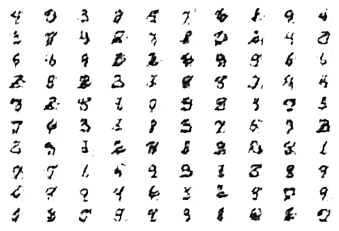

Classifier Accuracy: 83.552%
=> Saved: generated_plot_0600.png, g_model_0600.h5, and c_model_0600.h5
> Step 700: c_loss-acc[0.021, 100], d_loss[0.937, 0.583], g_loss[1.256]
> Step 800: c_loss-acc[0.024, 100], d_loss[0.583, 0.685], g_loss[1.228]
> Step 900: c_loss-acc[0.030, 100], d_loss[0.493, 0.878], g_loss[1.287]
> Step 1000: c_loss-acc[0.015, 100], d_loss[0.708, 0.746], g_loss[1.318]
> Step 1100: c_loss-acc[0.012, 100], d_loss[0.682, 0.734], g_loss[1.283]
> Step 1200: c_loss-acc[0.017, 100], d_loss[0.989, 0.494], g_loss[1.347]


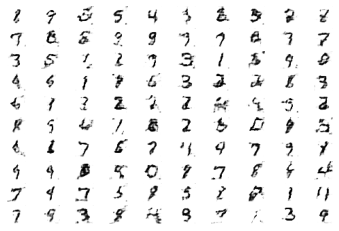

Classifier Accuracy: 89.868%
=> Saved: generated_plot_1200.png, g_model_1200.h5, and c_model_1200.h5
> Step 1300: c_loss-acc[0.011, 100], d_loss[0.535, 0.948], g_loss[1.372]
> Step 1400: c_loss-acc[0.030, 100], d_loss[0.766, 0.508], g_loss[1.364]
> Step 1500: c_loss-acc[0.024, 100], d_loss[0.540, 0.829], g_loss[1.268]
> Step 1600: c_loss-acc[0.005, 100], d_loss[0.933, 0.525], g_loss[1.398]
> Step 1700: c_loss-acc[0.010, 100], d_loss[0.660, 0.714], g_loss[1.199]
> Step 1800: c_loss-acc[0.014, 100], d_loss[0.695, 0.690], g_loss[1.240]


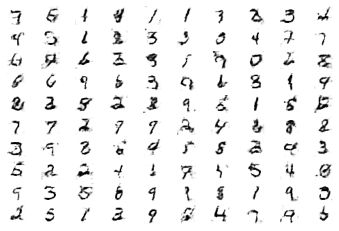

Classifier Accuracy: 91.348%
=> Saved: generated_plot_1800.png, g_model_1800.h5, and c_model_1800.h5
> Step 1900: c_loss-acc[0.006, 100], d_loss[0.672, 0.800], g_loss[1.261]
> Step 2000: c_loss-acc[0.004, 100], d_loss[0.809, 0.690], g_loss[1.337]
> Step 2100: c_loss-acc[0.009, 100], d_loss[0.494, 0.831], g_loss[1.362]
> Step 2200: c_loss-acc[0.009, 100], d_loss[0.723, 0.716], g_loss[1.411]
> Step 2300: c_loss-acc[0.006, 100], d_loss[0.636, 0.621], g_loss[1.204]
> Step 2400: c_loss-acc[0.004, 100], d_loss[0.836, 0.599], g_loss[1.395]


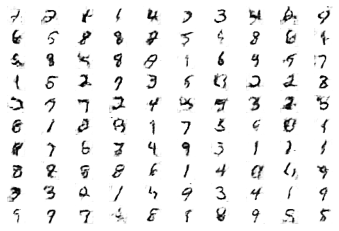

Classifier Accuracy: 92.930%
=> Saved: generated_plot_2400.png, g_model_2400.h5, and c_model_2400.h5
> Step 2500: c_loss-acc[0.008, 100], d_loss[0.498, 0.913], g_loss[1.254]
> Step 2600: c_loss-acc[0.006, 100], d_loss[0.527, 0.770], g_loss[1.267]
> Step 2700: c_loss-acc[0.004, 100], d_loss[0.573, 0.755], g_loss[1.138]
> Step 2800: c_loss-acc[0.006, 100], d_loss[0.683, 0.787], g_loss[1.047]
> Step 2900: c_loss-acc[0.003, 100], d_loss[0.702, 0.767], g_loss[1.180]
> Step 3000: c_loss-acc[0.007, 100], d_loss[0.600, 0.830], g_loss[1.222]


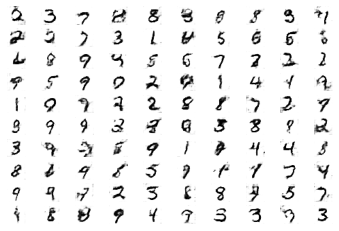

Classifier Accuracy: 93.633%
=> Saved: generated_plot_3000.png, g_model_3000.h5, and c_model_3000.h5
> Step 3100: c_loss-acc[0.004, 100], d_loss[0.655, 0.901], g_loss[1.071]
> Step 3200: c_loss-acc[0.003, 100], d_loss[0.747, 0.835], g_loss[1.180]
> Step 3300: c_loss-acc[0.004, 100], d_loss[0.676, 0.713], g_loss[1.063]
> Step 3400: c_loss-acc[0.002, 100], d_loss[0.722, 0.628], g_loss[1.288]
> Step 3500: c_loss-acc[0.002, 100], d_loss[0.745, 0.720], g_loss[1.250]
> Step 3600: c_loss-acc[0.003, 100], d_loss[0.731, 0.652], g_loss[1.278]


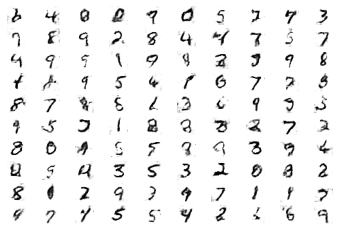

Classifier Accuracy: 93.803%
=> Saved: generated_plot_3600.png, g_model_3600.h5, and c_model_3600.h5
> Step 3700: c_loss-acc[0.004, 100], d_loss[0.593, 0.771], g_loss[1.078]
> Step 3800: c_loss-acc[0.003, 100], d_loss[0.600, 0.707], g_loss[1.278]
> Step 3900: c_loss-acc[0.004, 100], d_loss[0.820, 0.669], g_loss[1.102]
> Step 4000: c_loss-acc[0.004, 100], d_loss[0.790, 0.538], g_loss[1.201]
> Step 4100: c_loss-acc[0.002, 100], d_loss[0.811, 0.648], g_loss[1.021]
> Step 4200: c_loss-acc[0.002, 100], d_loss[0.743, 0.716], g_loss[1.198]


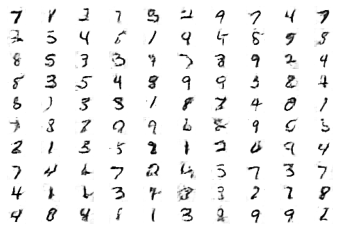

Classifier Accuracy: 94.500%
=> Saved: generated_plot_4200.png, g_model_4200.h5, and c_model_4200.h5
> Step 4300: c_loss-acc[0.002, 100], d_loss[0.752, 0.624], g_loss[1.263]
> Step 4400: c_loss-acc[0.005, 100], d_loss[0.692, 0.663], g_loss[1.082]
> Step 4500: c_loss-acc[0.003, 100], d_loss[0.725, 0.917], g_loss[1.065]
> Step 4600: c_loss-acc[0.004, 100], d_loss[0.659, 0.819], g_loss[1.193]
> Step 4700: c_loss-acc[0.003, 100], d_loss[0.697, 0.942], g_loss[0.989]
> Step 4800: c_loss-acc[0.002, 100], d_loss[0.747, 0.662], g_loss[1.114]


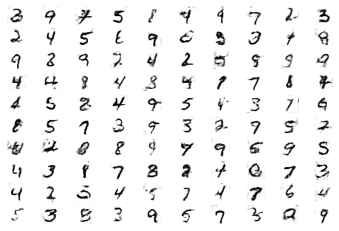

Classifier Accuracy: 94.603%
=> Saved: generated_plot_4800.png, g_model_4800.h5, and c_model_4800.h5
> Step 4900: c_loss-acc[0.003, 100], d_loss[0.676, 0.594], g_loss[1.210]
> Step 5000: c_loss-acc[0.003, 100], d_loss[0.622, 0.669], g_loss[1.183]
> Step 5100: c_loss-acc[0.003, 100], d_loss[0.518, 0.715], g_loss[1.235]
> Step 5200: c_loss-acc[0.002, 100], d_loss[0.765, 0.716], g_loss[1.097]
> Step 5300: c_loss-acc[0.002, 100], d_loss[0.728, 0.924], g_loss[1.106]
> Step 5400: c_loss-acc[0.001, 100], d_loss[0.858, 0.558], g_loss[1.063]


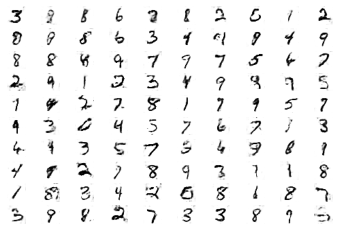

Classifier Accuracy: 94.788%
=> Saved: generated_plot_5400.png, g_model_5400.h5, and c_model_5400.h5
> Step 5500: c_loss-acc[0.001, 100], d_loss[0.790, 1.027], g_loss[1.125]
> Step 5600: c_loss-acc[0.002, 100], d_loss[0.839, 0.835], g_loss[1.120]
> Step 5700: c_loss-acc[0.001, 100], d_loss[0.616, 0.916], g_loss[1.059]
> Step 5800: c_loss-acc[0.004, 100], d_loss[0.982, 0.832], g_loss[1.260]
> Step 5900: c_loss-acc[0.001, 100], d_loss[0.805, 0.901], g_loss[1.051]
> Step 6000: c_loss-acc[0.002, 100], d_loss[0.770, 0.671], g_loss[1.153]


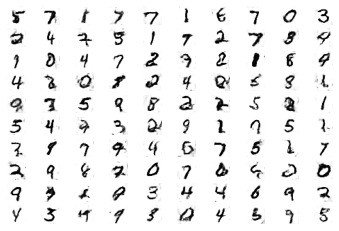

Classifier Accuracy: 93.902%
=> Saved: generated_plot_6000.png, g_model_6000.h5, and c_model_6000.h5
> Step 6100: c_loss-acc[0.001, 100], d_loss[1.002, 0.821], g_loss[1.214]
> Step 6200: c_loss-acc[0.001, 100], d_loss[0.737, 0.855], g_loss[1.222]
> Step 6300: c_loss-acc[0.002, 100], d_loss[0.742, 1.070], g_loss[1.142]
> Step 6400: c_loss-acc[0.001, 100], d_loss[0.726, 0.802], g_loss[1.198]
> Step 6500: c_loss-acc[0.002, 100], d_loss[0.898, 0.719], g_loss[1.142]
> Step 6600: c_loss-acc[0.002, 100], d_loss[0.910, 1.064], g_loss[1.302]


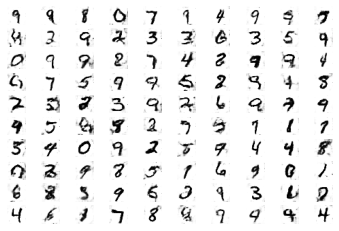

Classifier Accuracy: 93.980%
=> Saved: generated_plot_6600.png, g_model_6600.h5, and c_model_6600.h5
> Step 6700: c_loss-acc[0.008, 100], d_loss[1.164, 0.726], g_loss[1.358]
> Step 6800: c_loss-acc[0.001, 100], d_loss[0.878, 0.901], g_loss[1.036]
> Step 6900: c_loss-acc[0.001, 100], d_loss[0.883, 1.044], g_loss[1.248]
> Step 7000: c_loss-acc[0.001, 100], d_loss[0.803, 0.938], g_loss[1.087]
> Step 7100: c_loss-acc[0.001, 100], d_loss[0.734, 0.948], g_loss[0.992]
> Step 7200: c_loss-acc[0.001, 100], d_loss[0.857, 0.955], g_loss[1.211]


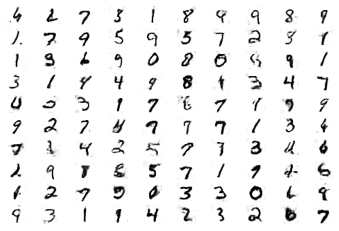

Classifier Accuracy: 94.908%
=> Saved: generated_plot_7200.png, g_model_7200.h5, and c_model_7200.h5
> Step 7300: c_loss-acc[0.001, 100], d_loss[0.835, 0.779], g_loss[1.236]
> Step 7400: c_loss-acc[0.001, 100], d_loss[0.718, 0.908], g_loss[1.178]
> Step 7500: c_loss-acc[0.001, 100], d_loss[0.571, 0.724], g_loss[1.121]
> Step 7600: c_loss-acc[0.001, 100], d_loss[1.005, 0.881], g_loss[1.048]
> Step 7700: c_loss-acc[0.001, 100], d_loss[0.802, 0.799], g_loss[1.175]
> Step 7800: c_loss-acc[0.001, 100], d_loss[0.575, 0.959], g_loss[1.080]


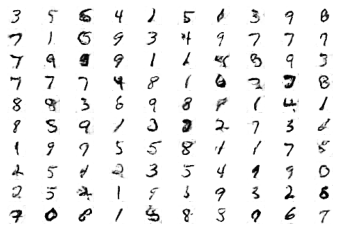

Classifier Accuracy: 94.903%
=> Saved: generated_plot_7800.png, g_model_7800.h5, and c_model_7800.h5
> Step 7900: c_loss-acc[0.001, 100], d_loss[0.967, 1.045], g_loss[1.197]
> Step 8000: c_loss-acc[0.001, 100], d_loss[0.812, 0.869], g_loss[1.391]
> Step 8100: c_loss-acc[0.001, 100], d_loss[1.041, 1.080], g_loss[1.149]
> Step 8200: c_loss-acc[0.001, 100], d_loss[1.031, 0.787], g_loss[1.068]
> Step 8300: c_loss-acc[0.001, 100], d_loss[0.925, 0.865], g_loss[1.189]
> Step 8400: c_loss-acc[0.001, 100], d_loss[0.804, 0.898], g_loss[1.147]


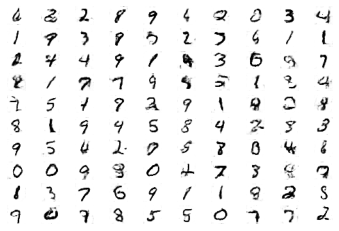

Classifier Accuracy: 94.007%
=> Saved: generated_plot_8400.png, g_model_8400.h5, and c_model_8400.h5
> Step 8500: c_loss-acc[0.001, 100], d_loss[0.861, 0.976], g_loss[1.366]
> Step 8600: c_loss-acc[0.001, 100], d_loss[0.910, 1.214], g_loss[1.136]
> Step 8700: c_loss-acc[0.001, 100], d_loss[0.779, 1.089], g_loss[1.197]
> Step 8800: c_loss-acc[0.001, 100], d_loss[0.983, 0.998], g_loss[1.051]
> Step 8900: c_loss-acc[0.000, 100], d_loss[0.728, 1.016], g_loss[1.142]
> Step 9000: c_loss-acc[0.001, 100], d_loss[0.789, 1.024], g_loss[1.011]


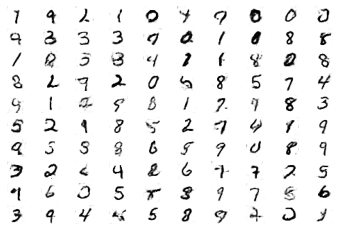

Classifier Accuracy: 94.170%
=> Saved: generated_plot_9000.png, g_model_9000.h5, and c_model_9000.h5
> Step 9100: c_loss-acc[0.001, 100], d_loss[0.920, 0.728], g_loss[1.212]
> Step 9200: c_loss-acc[0.001, 100], d_loss[0.968, 0.765], g_loss[1.144]
> Step 9300: c_loss-acc[0.001, 100], d_loss[0.748, 0.986], g_loss[1.166]
> Step 9400: c_loss-acc[0.001, 100], d_loss[0.785, 0.979], g_loss[1.328]
> Step 9500: c_loss-acc[0.001, 100], d_loss[0.740, 0.833], g_loss[1.286]
> Step 9600: c_loss-acc[0.000, 100], d_loss[0.844, 0.833], g_loss[1.262]


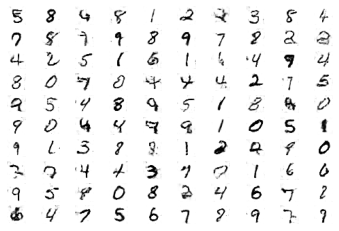

Classifier Accuracy: 94.653%
=> Saved: generated_plot_9600.png, g_model_9600.h5, and c_model_9600.h5
> Step 9700: c_loss-acc[0.001, 100], d_loss[0.582, 0.832], g_loss[1.265]
> Step 9800: c_loss-acc[0.001, 100], d_loss[0.722, 0.912], g_loss[1.090]
> Step 9900: c_loss-acc[0.001, 100], d_loss[0.923, 0.901], g_loss[1.208]
> Step 10000: c_loss-acc[0.001, 100], d_loss[0.868, 0.688], g_loss[1.076]
> Step 10100: c_loss-acc[0.001, 100], d_loss[0.616, 0.944], g_loss[1.015]
> Step 10200: c_loss-acc[0.001, 100], d_loss[1.303, 0.802], g_loss[1.213]


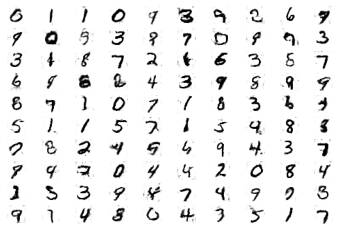

Classifier Accuracy: 94.572%
=> Saved: generated_plot_10200.png, g_model_10200.h5, and c_model_10200.h5
> Step 10300: c_loss-acc[0.001, 100], d_loss[0.802, 1.151], g_loss[1.352]
> Step 10400: c_loss-acc[0.001, 100], d_loss[1.174, 0.906], g_loss[1.221]
> Step 10500: c_loss-acc[0.000, 100], d_loss[1.062, 0.854], g_loss[1.179]
> Step 10600: c_loss-acc[0.009, 100], d_loss[0.927, 0.951], g_loss[0.931]
> Step 10700: c_loss-acc[0.002, 100], d_loss[0.904, 0.862], g_loss[1.229]
> Step 10800: c_loss-acc[0.003, 100], d_loss[0.727, 0.980], g_loss[1.005]


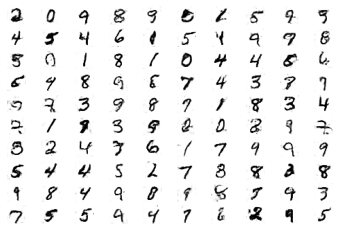

Classifier Accuracy: 93.393%
=> Saved: generated_plot_10800.png, g_model_10800.h5, and c_model_10800.h5
> Step 10900: c_loss-acc[0.001, 100], d_loss[0.874, 1.062], g_loss[1.090]
> Step 11000: c_loss-acc[0.002, 100], d_loss[0.840, 0.719], g_loss[1.110]
> Step 11100: c_loss-acc[0.002, 100], d_loss[0.682, 0.976], g_loss[1.105]
> Step 11200: c_loss-acc[0.001, 100], d_loss[0.800, 0.989], g_loss[0.971]
> Step 11300: c_loss-acc[0.004, 100], d_loss[0.652, 0.840], g_loss[1.108]
> Step 11400: c_loss-acc[0.005, 100], d_loss[0.808, 0.974], g_loss[1.104]


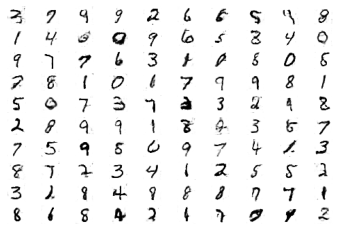

Classifier Accuracy: 93.048%
=> Saved: generated_plot_11400.png, g_model_11400.h5, and c_model_11400.h5
> Step 11500: c_loss-acc[0.002, 100], d_loss[0.807, 0.875], g_loss[1.061]
> Step 11600: c_loss-acc[0.002, 100], d_loss[0.930, 1.015], g_loss[1.158]
> Step 11700: c_loss-acc[0.003, 100], d_loss[0.949, 0.993], g_loss[1.212]
> Step 11800: c_loss-acc[0.001, 100], d_loss[0.796, 0.830], g_loss[1.070]
> Step 11900: c_loss-acc[0.004, 100], d_loss[0.765, 0.838], g_loss[1.123]
> Step 12000: c_loss-acc[0.004, 100], d_loss[0.731, 0.872], g_loss[1.009]


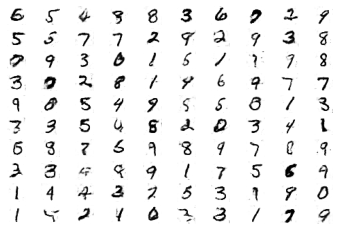

Classifier Accuracy: 93.393%
=> Saved: generated_plot_12000.png, g_model_12000.h5, and c_model_12000.h5


In [16]:
train(g_model, d_model, c_model, gan_model, dataset, latent_dim)